# Getting Started with Topic Modelling

*This notebook first appeared as a [blog post](//betatim.github.io/posts/start-topic-modelling) on [Tim Head](//betatim.github.io)'s blog.*

*License: [MIT](http://opensource.org/licenses/MIT)*

*(C) 2016, Tim Head.*
*Feel free to use, distribute, and modify with the above attribution.*

This is a short post on getting started with [topic modelling](https://en.wikipedia.org/wiki/Topic_model).

The classic use-case is to discover the topics that a collection
of documents belong to. This is not a method for putting documents
into predefined groups. Topic modelling is about discovering
possible groups (or topics) and then assigning documents to
each one.

For the smart kids: a document does not have to consist of words.
You could also use this to discover groups within a collection
of images or a group of people.

This post will use questions posted to [stack overflow]() and
released by them as part of their [data dump](http://blog.stackoverflow.com/category/cc-wiki-dump). The data is licensed under [cc-by-sa](http://creativecommons.org/licenses/by-sa/2.5/). The nice people
from Facebook took the data and preprocessed it for a [kaggle
competition](https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction)
and I am using that data.

Without further ado: let's get modelling.

In [2]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

In [3]:
from html.parser import HTMLParser

import numpy as np
np.random.seed(3)
import matplotlib.pyplot as plt

import pandas as pd

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import fetch_20newsgroups

import pyLDAvis
pyLDAvis.enable_notebook()

There are about 2million questions in this dataset, to speed
things up I only use the first 100000.

In [4]:
fname = '/Users/thead/Downloads/Train.csv'
df = pd.read_csv(fname, nrows=100000, index_col='Id', engine='c')

## Clean text

The questions still contain HTML tags and some code fragments.
I decided to remove the code fragments and discard all other
tags. Leaving us with just the text.

The title of a question will most likely contain a lot of hints
about the topic of the question so I create a new column in the
data frame which combines the title and the body.

In [5]:
class TextExtractor(HTMLParser):
    def __init__(self):
        super().__init__()
        self.in_code = False
        self.text = []
        
    def handle_starttag(self, tag, attrs):
        if tag == 'code':
            self.in_code = True

    def handle_endtag(self, tag):
        if tag == 'code':
            self.in_code = False

    def handle_data(self, data):
        if not self.in_code:
            self.text.append(data)


def clean_body(body):
    extractor = TextExtractor()
    extractor.feed(body)
    return ' '.join(extractor.text)


df['CleanBody'] = df.Body.map(clean_body)
df['Text'] = df.apply(lambda x: x.Title +' '+x.CleanBody, axis=1)
df.drop(['Tags', 'Body', 'Title', 'CleanBody'], axis=1, inplace=True)
df = df.iloc[np.random.permutation(len(df))]
df.head()

/Users/thead/anaconda/envs/skopt/lib/python3.5/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/thead/anaconda/envs/skopt/lib/python3.5/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


,Text
Id,
79529,Is it bad practice to use public fields? \n ...
53877,Direct3D acceleration in VMware workstation I ...
9778,Obj C MD5 differs from PHP md5() function I'm ...
6168,Design pattern for Method parameter I have a s...
22021,How to check any thread is working currently I...


Now we have our data, how do we discover topics?


## Latent Dirichlet Allocation

Say what? If you are mathematically inclined read about [LDA](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) on
wikipedia. Here is my attempt at a two sentence explanation:

A document is made of several words. Why are these particular
words in this document? Because the document belongs to a
topic that uses these words!

Simple. Not really. Another way to think about this is that
a speaker on a certain topic "generates" words according to
certan probabilities. Someone speaking about pets is quite
likely to say words like "cat", "dog", "hamster" and less
likely to say "beer", "crisps" or "football".

What LDA does is answer the question: given these
transcripts what are the speakers that are most likely to
create these transcripts and what is the favourite topic
of each speaker?

A nice feature of LDA is that a document can belong 50%
to the pets topic/speaker, 30% to the pub-conversation
topic/speaker and 20% to a third topic. You do not have
to pick just one topic.


## Show me some code

The magic ingredient is not really that magic. We first
convert each document into a vector that counts how often
each word appears in that document (ignoring stop words,
words that appear very frequently and very rarely)

One parameter we have to guess is how many topics there
are. There are quantitative methods for determining this
value but here I experimented a bit and then choose six.

In [23]:
# normalise entries in an array so they sum to one
def norm(a):
    a = np.asarray(a)
    return a/(a.sum(axis=1)[:,np.newaxis])

def norm_(a):
    a = np.asarray(a)
    return a/a.sum()

# This is where the magic happens!
vect = CountVectorizer(stop_words='english', max_df=0.95, min_df=2)
lda = LatentDirichletAllocation(n_topics=4, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=4)

# I am impatient, so in the interest of
# CPU time consider just the first 30000 questions
docs = df.Text[:30000]


vectorised = vect.fit_transform(docs)
doc_topic_prob = lda.fit_transform(vectorised)

Now what? We created six topics and for each question
calculated the mixture of topics it belongs to. We have
no idea about what the six topics represent though. To try
and identify each topic we can look at what words are
important for each topic and use those to
assign a human readable label to each topic ([code from here](http://scikit-learn.org/dev/auto_examples/applications/topics_extraction_with_nmf_lda.html))

In [24]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % (topic_idx+1))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
    
print_top_words(lda, vect.get_feature_names(), 15)

Topic #1:
like table number query data way function string use array want example using question need
Topic #2:
code using like want page use way user class method thanks need problem text data
Topic #3:
server application web using java error app service client user com database android use net
Topic #4:
file windows files using use like just run ve know way does time work project



What could the topics be about? Here my gueses:

1. not sure
2. a lot of LaTeX terms, maybe these are maths questions
3. webservers and apps, using PHP
4. questions about java, XML and OO. Business code?
5. not sure
6. this looks like questions about HTML on mobile platforms

Selecting a few documents 

In [32]:
topic = doc_topic_prob[:, 3] > 0.9

for n, doc in enumerate(docs[topic]):
    print(doc)
    print('~' * 80)
    if n > 10:
        break

Direct3D acceleration in VMware workstation I would like to virtualize Blizzard's Direct3D game - SC2. Is it ok to do it on a Linux host or do I have to change it to Windows 7? Are there some significant performance differences in Direct3D virtualization in general, regarding the host OS ? 

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
device not working with mapkit my device doenst work at all when i load an project that contains any mapkit framework files
it says 

 ld: warning: in /APP/MapKit.framework/MapKit, file was built for i386 which is not the architecture being linked (armv6) 

 and it doesnt let me test it on the device, however when i load this on my simulator it works.
Any help? 

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running shell commands in .sh file results to error I have two following linux shell commands: 

 

 When i run these commands directly in Terminal, i get this result truly: 

 



In [ ]:
order = np.argsort(doc_topic_prob[:, 0], axis=0)
dd = np.zeros_like(doc_topic_prob)
for i in range(6):
    dd[:, i] = doc_topic_prob[order, i]
plt.imshow(dd[:10, :], aspect='normal', interpolation='nearest', cmap='Blues')

In [9]:
import seaborn as sns

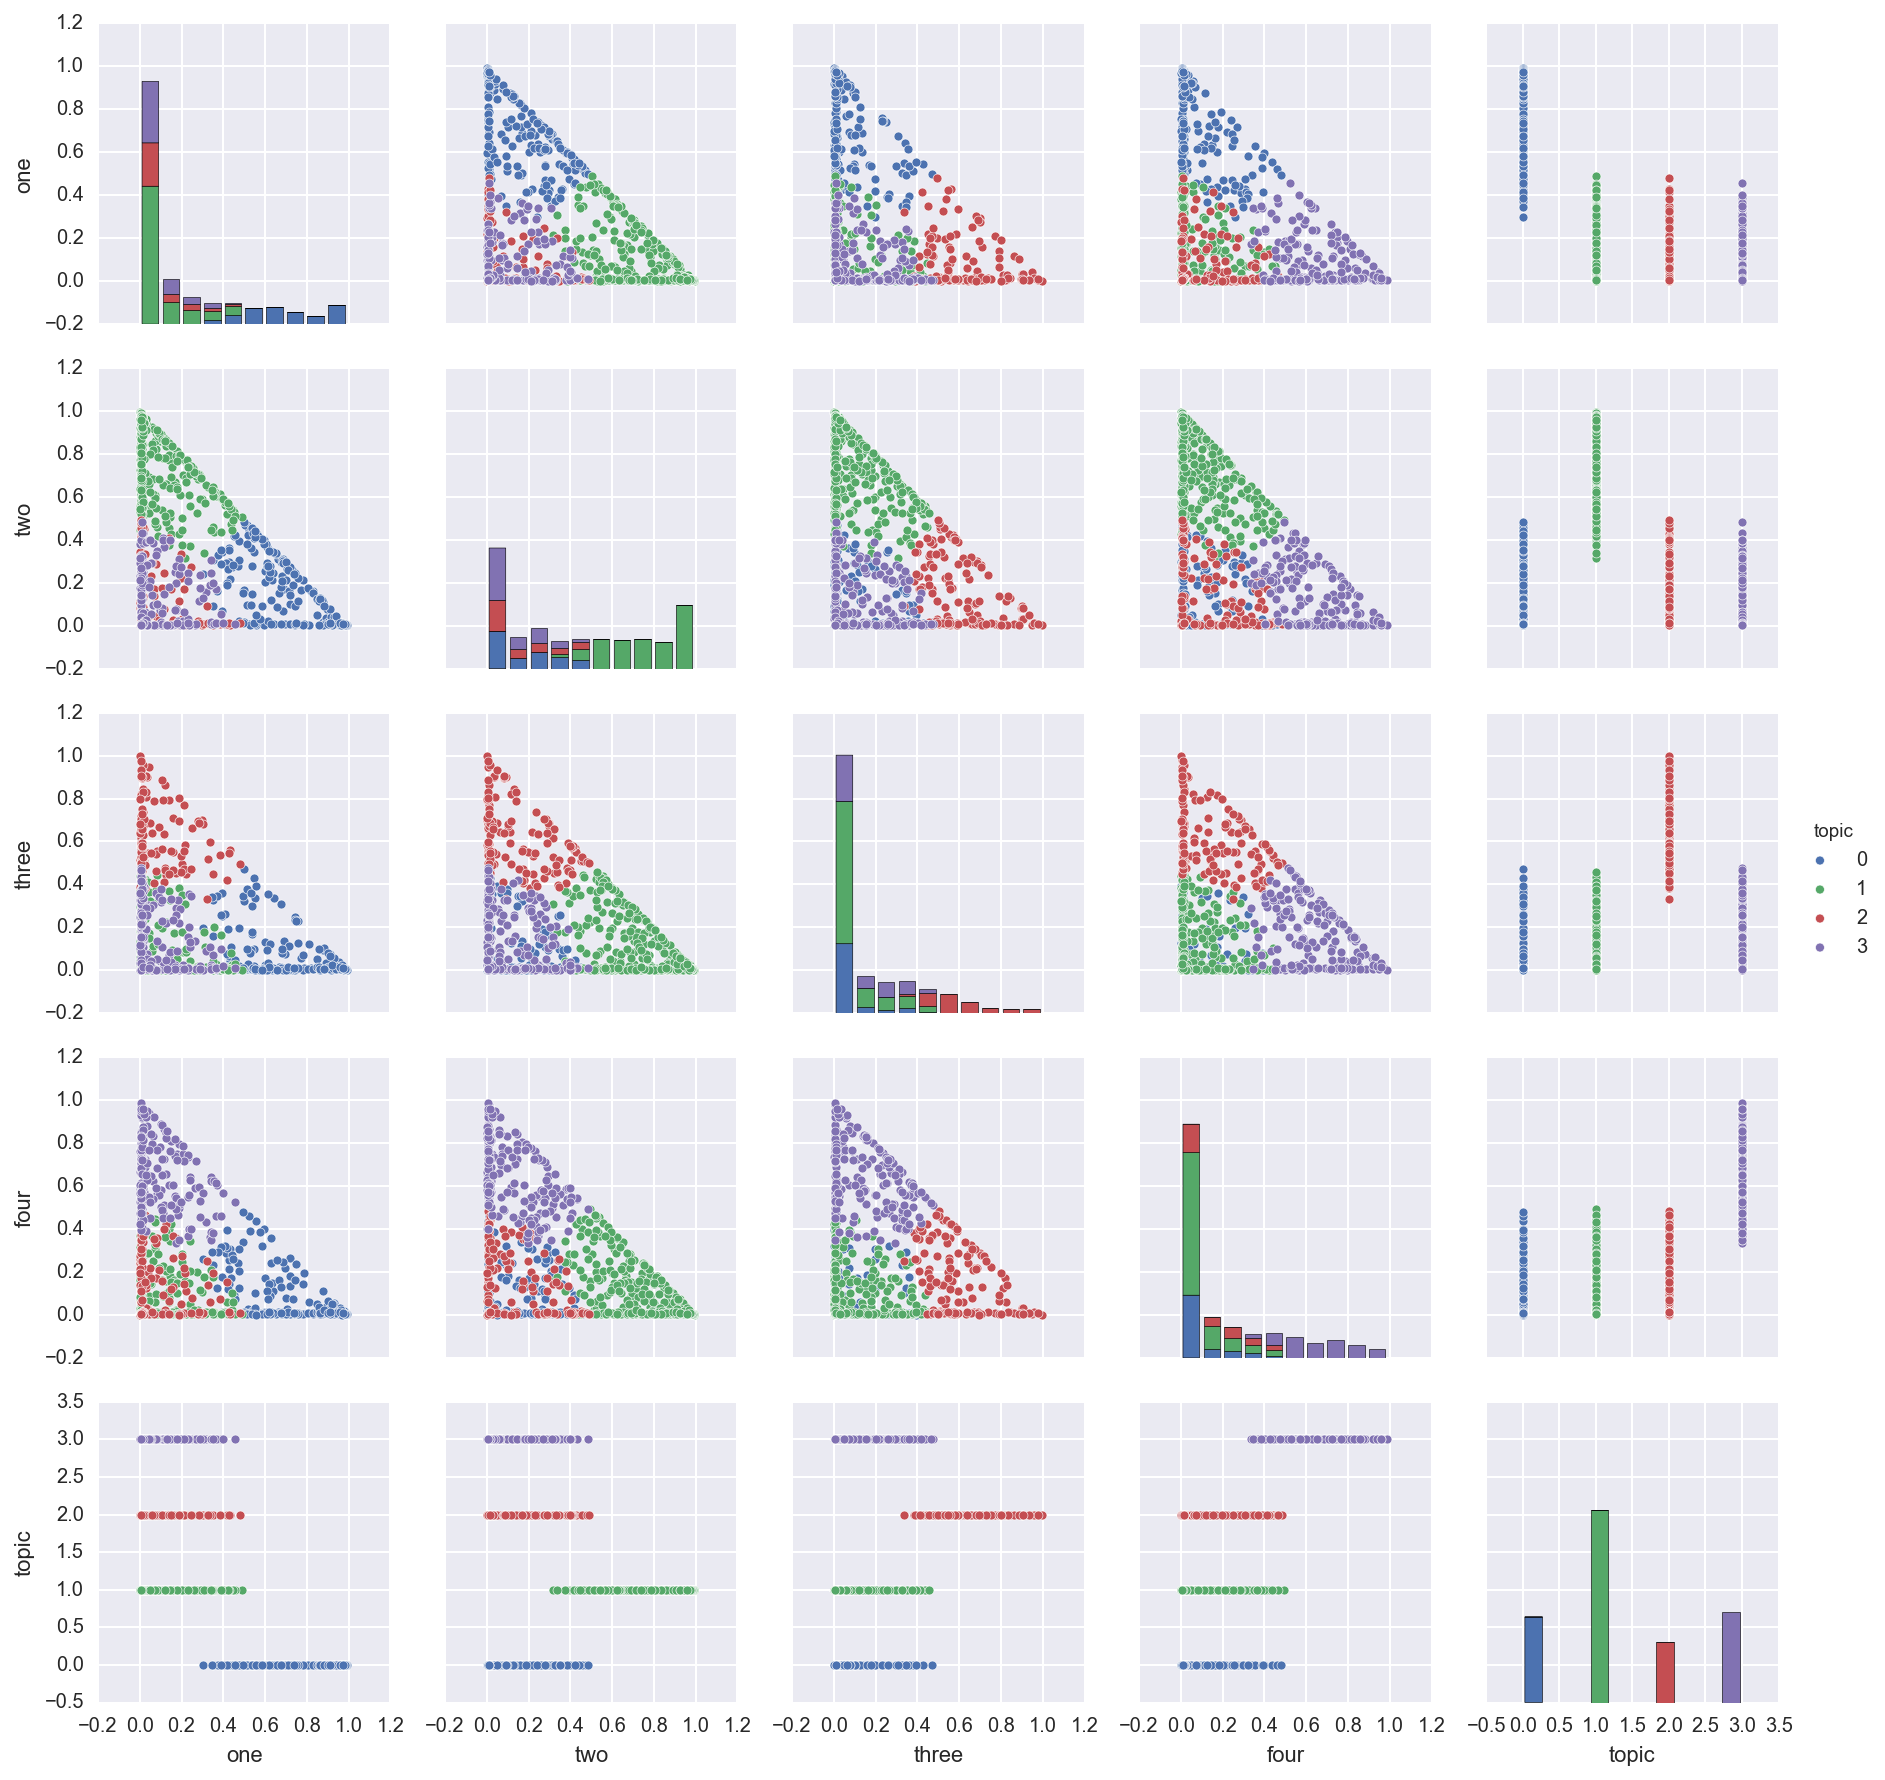

In [26]:
fg = pd.DataFrame(doc_topic_prob, columns=["one", 'two', 'three',
                                           'four', 
                                           #'five', 'six', 'seven'
                                          ])
fg['topic'] = np.argmax(doc_topic_prob, axis=1)
sns.pairplot(fg.sample(1000), hue='topic')

In [28]:
opts = dict(vocab=vect.get_feature_names(),
            doc_topic_dists=norm(doc_topic_prob),
            doc_lengths=np.array((vectorised != 0).sum(1)).squeeze(),
            topic_term_dists=norm(lda.components_),
            term_frequency=norm_(vectorised.sum(axis=0).tolist()[0]),)
import warnings
warnings.filterwarnings('ignore')
pyLDAvis.prepare(**opts, mds='tsne')

PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
1      39.672432        1       1   17.763761  -85.785731
3      24.130346        1       2  -12.697315   93.656879
0      20.308158        1       3  177.373496  -99.943876
2      15.889065        1       4 -172.899270  104.068965, topic_info=      Category         Freq         Term        Total  loglift  logprob
term                                                                   
17352  Default  4564.000000       server  4564.000000  30.0000  30.0000
21429  Default  2749.000000      windows  2749.000000  29.0000  29.0000
14037  Default  3805.000000         page  3805.000000  28.0000  28.0000
2141   Default  3678.000000  application  3678.000000  27.0000  27.0000
21217  Default  2310.000000          web  2310.000000  26.0000  26.0000
7804   Default  2705.000000        files  2705.000000  25.0000  25.0000
7772   Default  6254.000000         file  6254.000000  24.0000  24.0000
10664  Default  2373.000000         java  2373.000000  23.0000  23.0000
17363  Default  1363.000000      service  1363.000000  22.0000  22.0000
19115  Default  2509.000000        table  2509.000000  21.0000  21.0000
7138   Default  4257.000000        error  4257.000000  20.0000  20.0000
4166   Default  1236.000000       client  1236.000000  19.0000  19.0000
2081   Default  2867.000000          app  2867.000000  18.0000  18.0000
13376  Default  1703.000000       number  1703.000000  17.0000  17.0000
15561  Default  1519.000000        query  1519.000000  16.0000  16.0000
1947   Default  1577.000000      android  1577.000000  15.0000  15.0000
20923  Default  2097.000000         view  2097.000000  14.0000  14.0000
8325   Default  3032.000000     function  3032.000000  13.0000  13.0000
20640  Default  4063.000000         user  4063.000000  12.0000  12.0000
4386   Default  2129.000000          com  2129.000000  11.0000  11.0000
9448   Default  1928.000000         html  1928.000000  10.0000  10.0000
13032  Default  2119.000000          net  2119.000000   9.0000   9.0000
2308   Default  1765.000000        array  1765.000000   8.0000   8.0000
18561  Default  2123.000000       string  2123.000000   7.0000   7.0000
5394   Default  2272.000000     database  2272.000000   6.0000   6.0000
3503   Default  1774.000000       button  1774.000000   5.0000   5.0000
9717   Default  2024.000000        image  2024.000000   4.0000   4.0000
20769  Default  2542.000000        value  2542.000000   3.0000   3.0000
18242  Default  1500.000000          sql  1500.000000   2.0000   2.0000
4420   Default  1274.000000      command  1274.000000   1.0000   1.0000
...        ...          ...          ...          ...      ...      ...
6833    Topic4   590.277850        email   645.672107   1.7498  -5.6064
21217   Topic4  1890.352772          web  2310.471975   1.6389  -4.4425
17359   Topic4   330.170756      servers   353.364081   1.7717  -6.1874
13820   Topic4   561.346990          org   644.596499   1.7013  -5.6567
16353   Topic4   292.112477     requests   309.945047   1.7803  -6.3099
10664   Topic4  1748.939792         java  2373.166048   1.5343  -4.5203
17385   Topic4   448.435072      session   517.551866   1.6962  -5.8813
11596   Topic4   567.334418        login   693.531505   1.6387  -5.6461
2141    Topic4  2188.632350  application  3678.286533   1.3204  -4.2960
17271   Topic4   678.015762         send   871.413133   1.5886  -5.4679
14218   Topic4   425.835576     password   489.483082   1.7002  -5.9330
1947    Topic4  1041.813974      android  1577.033686   1.4250  -5.0383
1571    Topic4   553.208381      address   708.958784   1.5915  -5.6713
16341   Topic4   673.034584      request   953.157749   1.4916  -5.4752
2081    Topic4  1394.042475          app  2867.921423   1.1182  -4.7471
1370    Topic4   969.444256       access  1698.331534   1.2789  -5.1103
4386    Topic4  1112.407828          com  2129.154144   1.1903  -4.9728
7138    T